In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
#from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2024-02-09 17:30:07.489356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 17:30:07.489471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 17:30:07.802288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'

In [3]:
test_data='/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'

In [4]:
def get_data(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

X_train, Y_train, labels = get_data(train_data)
X_test, Y_test,_ = get_data(test_data)

In [5]:
from keras.utils import to_categorical

In [6]:
Y_train = to_categorical(Y_train, 131)
Y_test = to_categorical(Y_test, 131)

In [7]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=33)
Y_train, Y_val = train_test_split(Y_train, test_size=0.2, random_state=33)

In [8]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

In [9]:
X_train = np.array(convert_image_to_array(X_train))
X_val = np.array(convert_image_to_array(X_val))
X_test = np.array(convert_image_to_array(X_test))

In [10]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [11]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, Attention, Input

# Define the CNN model with attention
model = Sequential()

# Input shape is 100x100 since that's the dimension of each fruit image
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(100, 100, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))

# Applying attention after the last convolutional layer
attention = Attention()([model.layers[-1].output, model.layers[-1].output])

# Fully connected layers
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(150))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(131, activation='softmax'))

# Creating the model with attention
model_with_attention = Model(inputs=model.input, outputs=model.output)

# Displaying the summary of the model
model_with_attention.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      208       
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 32)        0         
 g2D)                                                        

In [12]:
from keras.optimizers import SGD, Adam, RMSprop

optimizer = Adam()
model_with_attention.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [13]:
checkpointer = ModelCheckpoint(filepath = 'cnn_from_scratch_fruits.hdf5', verbose = 1, save_best_only = True)

In [14]:
history = model_with_attention.fit(X_train,Y_train,
        batch_size = 128,
        epochs=20,
        validation_data=(X_val, Y_val),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/20


2024-02-09 17:42:46.391332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707500570.856249     484 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.15277, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 26s - loss: 1.8956 - accuracy: 0.5084 - val_loss: 0.1528 - val_accuracy: 0.9619 - 26s/epoch - 61ms/step
Epoch 2/20


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.15277 to 0.03928, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 13s - loss: 0.4032 - accuracy: 0.8659 - val_loss: 0.0393 - val_accuracy: 0.9908 - 13s/epoch - 30ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.03928 to 0.02867, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 13s - loss: 0.2533 - accuracy: 0.9135 - val_loss: 0.0287 - val_accuracy: 0.9912 - 13s/epoch - 30ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.02867 to 0.01637, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 13s - loss: 0.1939 - accuracy: 0.9323 - val_loss: 0.0164 - val_accuracy: 0.9953 - 13s/epoch - 31ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.01637 to 0.00706, saving model to cnn_from_scratch_fruits.hdf5
424/424 - 13s - loss: 0.1594 - accuracy: 0.9439 - val_loss: 0.0071 - val_accuracy: 0.9982 - 13s/epoch - 31ms/step
Epoch 6/20

Epoch 6: val_loss did not improve from 0.00706
424/424 - 13s - loss: 0.1387 - accuracy: 0.9517 - val_loss: 

In [15]:
score = model_with_attention.evaluate(X_test, Y_test)
print('Test accuracy:', score[1])

709/709 [==============================] - 4s 5ms/step - loss: 0.1204 - accuracy: 0.9825
Test accuracy: 0.9825458526611328


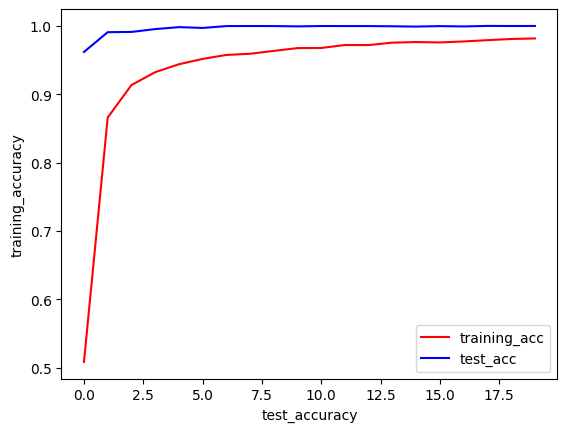

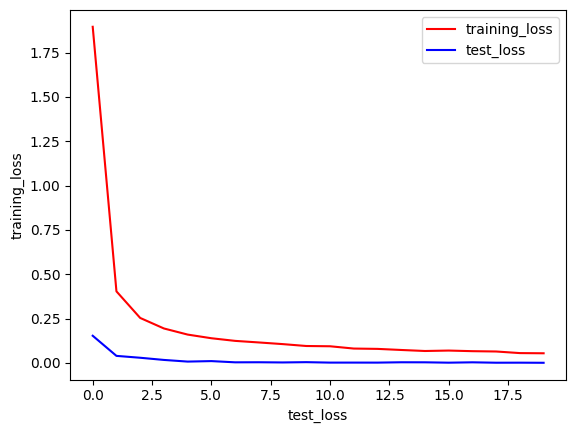

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color = 'red',label = 'training_acc')
plt.plot(history.history['val_accuracy'],color = 'blue',label = 'test_acc')
plt.ylabel('training_accuracy')
plt.xlabel('test_accuracy')
plt.legend()
plt.show()




plt.plot(history.history['loss'],color = 'red',label = 'training_loss')
plt.plot(history.history['val_loss'],color = 'blue',label = 'test_loss')
plt.ylabel('training_loss')
plt.xlabel('test_loss')
plt.legend()
plt.show()


709/709 [==============================] - 2s 3ms/step


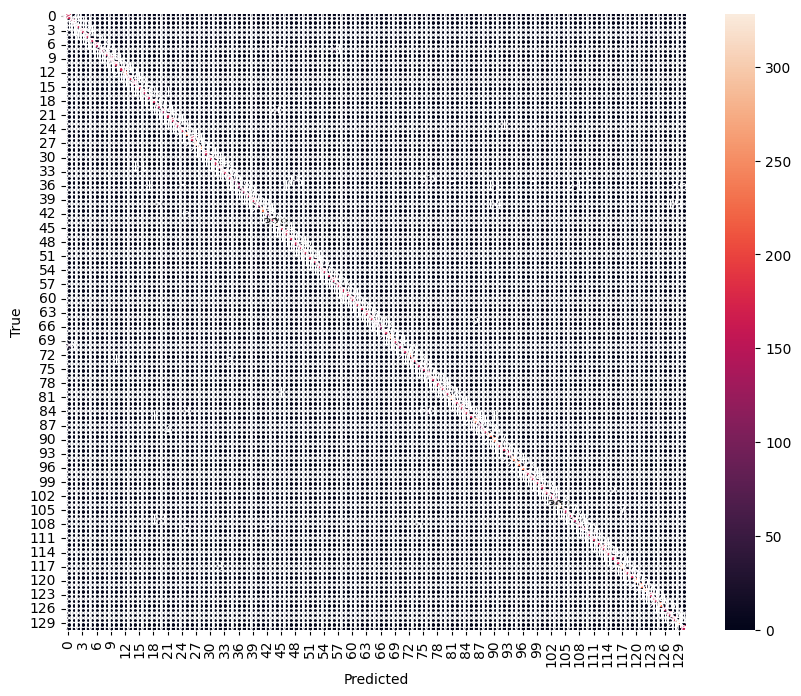

709/709 [==============================] - 4s 5ms/step - loss: 0.1204 - accuracy: 0.9825
Test accuracy is 0.9825458526611328 and test loss is 0.12038935720920563


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


y_pred = model_with_attention.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(np.argmax(Y_test, axis=1), y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test_loss, test_acc = model_with_attention.evaluate(X_test, Y_test)
print(f"Test accuracy is {test_acc} and test loss is {test_loss}")


In [18]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test set
Y_pred = model_with_attention.predict(X_test)
# Convert predictions to one-hot encoded labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
Y_true_labels = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)

# Classification Report
class_report = classification_report(Y_true_labels, Y_pred_labels)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


709/709 [==============================] - 2s 3ms/step
Confusion Matrix:
[[164   0   0 ...   0   0   0]
 [  0 148   0 ...   0   0   0]
 [  0   0 160 ...   0   0   0]
 ...
 [  0   0   0 ... 158   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 157]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       164
           1       1.00      1.00      1.00       148
           2       1.00      1.00      1.00       160
           3       1.00      1.00      1.00       164
           4       0.99      1.00      0.99       161
           5       1.00      0.99      0.99       164
           6       1.00      1.00      1.00       152
           7       1.00      0.72      0.84       164
           8       0.96      1.00      0.98       164
           9       1.00      1.00      1.00       144
          10       0.99      1.00      1.00       166
          11       1.00      1.00      1.00       164
        

In [19]:
from tensorflow.keras.applications import VGG16

In [22]:
vgg16 = VGG16(weights='imagenet',include_top = False,input_shape = (100,100,3))
vgg16.trainable = False

In [23]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [26]:
transfer_learning = Sequential()
transfer_learning.add(vgg16)
transfer_learning.add(Conv2D(1024, kernel_size=3, padding='same'))
transfer_learning.add(Activation('relu')) 
transfer_learning.add(MaxPooling2D(pool_size=(2, 2)))
transfer_learning.add(Dropout(0.3))
transfer_learning.add(Flatten())
transfer_learning.add(Dense(150))
transfer_learning.add(Activation('relu'))
transfer_learning.add(Dropout(0.3))
transfer_learning.add(Dense(131,activation = 'softmax'))

In [27]:
transfer_learning.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 1024)        4719616   
                                                                 
 activation_3 (Activation)   (None, 3, 3, 1024)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 1024)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 1, 1024)        0         
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                      

In [28]:
transfer_learning.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [1]:
history = transfer_learning.fit(X_train,Y_train, 
                                 batch_size = 128, 
                                 epochs=20, 
                                 validation_data=(X_val, Y_val), 
                                 verbose=2, shuffle=True)

NameError: name 'transfer_learning' is not defined